In [19]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import cv2 as cv

In [2]:
%run -i ../ownlib/RIW-Library.ipynb
%run -i ../ownlib/Utility.ipynb

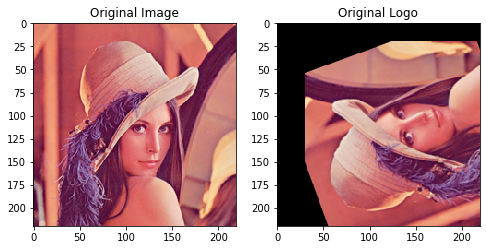

In [4]:
img1 = cv2.imread('lena.png')
img2 = np.copy(img1)
img2 = attackRotation(img2, 110)
# img2 = attackBlur(img2, 3)
# img2 = attackRandomNoise(img2, 0.03)
img2 = attackTranslateByPixel(img2, 30, 20)

imgshow([[img1, img2]], [['Original Image', 'Original Logo']])

In [15]:
def kp2pt(kp):
    (px, py) = kp.pt
    return (int(px), int(py))

def getPairs(keypointmathces, keypoints1, keypoints2):
    pairs = []
    for mt in keypointmathces:
        p1 = keypoints1[mt.queryIdx]
        p2 = keypoints2[mt.trainIdx]
        pairs.append((kp2pt(p1), kp2pt(p2)))
    return pairs

def calcDist(pa, pb):
    (pax, pay) = pa
    (pbx, pby) = pb
    dx = pax - pbx
    dy = pay - pby
    return np.sqrt(dx * dx + dy * dy)

def addTupple(t1, t2):
    (t1x, t1y) = t1
    (t2x, t2y) = t2
    return (t1x + t2x, t1y + t2y)

def calcError(keypointmathces, keypoints1, keypoints2, center, td):
    pairs = getPairs(keypointmathces, keypoints1, keypoints2)
    c2 = addTupple(center, td)
    sum = 0
    for (p1, p2) in pairs:
        d1 = calcDist(p1, center)
        d2 = calcDist(p2, c2)
        sum += abs(d1 - d2)
    return sum

def optimizeCenter(keypointmathces, keypoints1, keypoints2, center):
    dx = 0
    dy = 0
    step = 0.1
    for i in range(2000):
        if(i%2 == 0):
            e1 = calcError(keypointmathces[:50], keypoints1, keypoints2, center, (dx + step, dy))
            e2 = calcError(keypointmathces[:50], keypoints1, keypoints2, center, (dx - step, dy))
            if(e1 < e2):
                dx += step
            else:
                dx -= step
        else:
            e1 = calcError(keypointmathces[:50], keypoints1, keypoints2, center, (dx, dy + step))
            e2 = calcError(keypointmathces[:50], keypoints1, keypoints2, center, (dx, dy - step))
            if(e1 < e2):
                dy += step
            else:
                dy -= step
    return (int(np.round(-dx)), int(np.round(-dy)))

In [16]:
def correctTranslate(original, attacked, center):
    
    # Initiate ORB detector
    orb = cv2.ORB_create()
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(original,None)
    kp2, des2 = orb.detectAndCompute(attacked,None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    
    (tx, ty) = optimizeCenter(matches[:50], kp1, kp2, center)
    
    img_corr = attackTranslateByPixel(attacked, tx, ty)
    
    return (img_corr, (tx, ty))

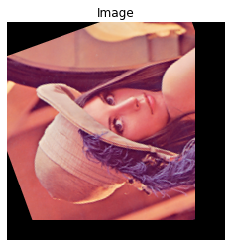

In [17]:
(img, center) = correctTranslate(img1, img2, (109.5, 109.5))
imgshow1(img, 'Image')

In [20]:
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [21]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:50],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

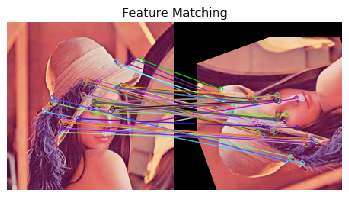

In [22]:
imgshow1(img3, 'Feature Matching')

-30 -20


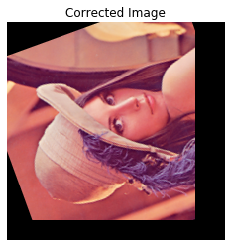

In [23]:
(tx, ty) = optimizeCenter(matches[:50], kp1, kp2, (109.5, 109.5))
print(tx, ty)
img_corr = attackTranslateByPixel(img2, tx, ty)
imgshow1(img_corr, 'Corrected Image')

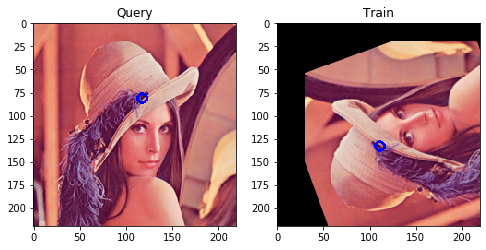

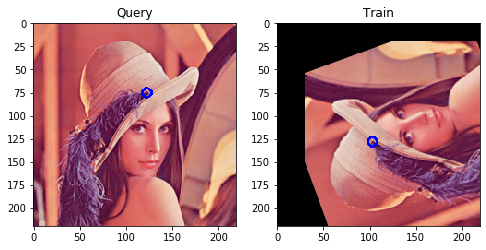

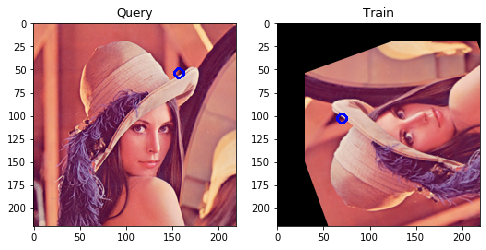

In [24]:
for pair in getPairs(matches[:3], kp1, kp2):
    (p1, p2) = pair
    img1edit = cv2.circle(np.copy(img1), p1, 5, (255, 0, 0), 2) 
    img2edit = cv2.circle(np.copy(img2), p2, 5, (255, 0, 0), 2)
    imgshow([[img1edit, img2edit]], [['Query', 'Train']])

1.0